<a href="https://colab.research.google.com/github/Lazi-Algorithm/Lazi-Algorithm/blob/main/SPAM_DETECTOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# library for train test split
from sklearn.model_selection import train_test_split

#deep learning libraries for text pre-processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#Modeling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional,Flatten

In [ ]:
url = 'https://raw.githubusercontent.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/master/SMSSpamCollection'
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])

In [ ]:
messages.to_csv("drive/MyDrive/SpamDetector/spam.csv")

In [ ]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
messages.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [ ]:
data = messages.copy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


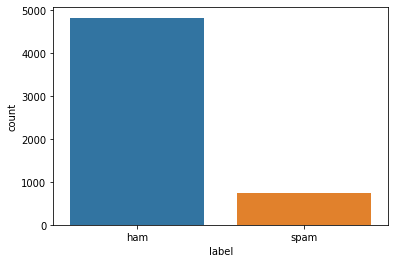

In [ ]:
sns.countplot(data['label'])
plt.show()

In [ ]:
data['label'] = data['label'].map( {'spam': 1, 'ham': 0} )

In [ ]:
data_ham  = data[data['label'] == 0].copy()
data_spam = data[data['label'] == 1].copy()

In [ ]:
def show_wordcloud(df, title):
    text = ' '.join(df.astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

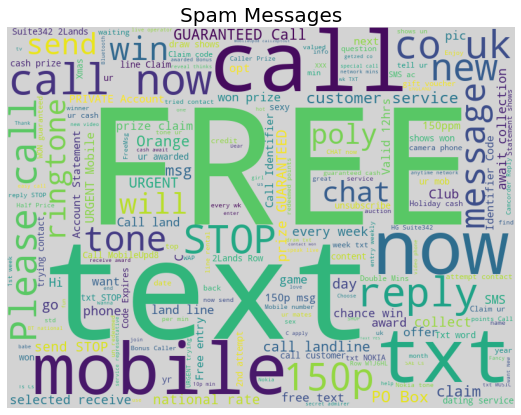

In [ ]:
show_wordcloud(data_spam["message"],"Spam Messages")

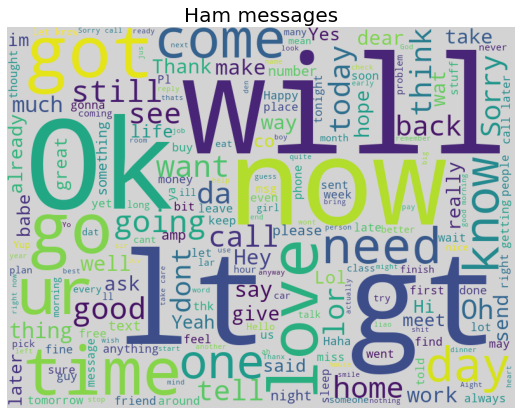

In [ ]:
show_wordcloud(data_ham["message"], "Ham messages")

Preparing Data for Training

In [ ]:
X = data['message'].values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)

In [ ]:
# integer encode the documents
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)
print(encoded_train[0:2])

[[87, 2, 172, 485, 461, 121, 33, 5, 3857, 3858, 315, 1268, 30, 2603, 67, 82, 2, 1657, 2, 316, 238], [246, 873, 15, 54, 8, 462, 160, 21, 25, 95, 1658, 77, 1, 61, 1120, 3859, 33, 174, 3, 53, 2604]]


In [ ]:
# pad documents to a max length of 8words
max_length = 8
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
print(padded_train)

[[2603   67   82 ...    2  316  238]
 [  61 1120 3859 ...    3   53 2604]
 [  49   85   97 ...    6  247   99]
 ...
 [1640   31 2485 ...  254   31 2486]
 [ 944 1460 1197 ...    0    0    0]
 [ 116   74   37 ...    9 3219 1396]]


In [ ]:
#model setup
vocab_size = len(t.word_index) +1

#define model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


#compile model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 24)             190896    
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               96500     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
model.fit(x=padded_train,
         y=y_train,
         epochs=50,
         validation_data=(padded_test, y_test), verbose=1,
         callbacks=[early_stop]
         )

Epoch 1/50
140/140 [==============================] - 2s 9ms/step - loss: 0.3057 - accuracy: 0.8804 - val_loss: 0.0910 - val_accuracy: 0.9749
Epoch 2/50
140/140 [==============================] - 1s 7ms/step - loss: 0.0457 - accuracy: 0.9882 - val_loss: 0.1112 - val_accuracy: 0.9758
Epoch 3/50
140/140 [==============================] - 1s 7ms/step - loss: 0.0081 - accuracy: 0.9977 - val_loss: 0.1196 - val_accuracy: 0.9794
Epoch 4/50
140/140 [==============================] - 1s 7ms/step - loss: 0.0026 - accuracy: 0.9989 - val_loss: 0.1924 - val_accuracy: 0.9830
Epoch 5/50
140/140 [==============================] - 1s 6ms/step - loss: 6.4155e-04 - accuracy: 0.9996 - val_loss: 0.2298 - val_accuracy: 0.9830
Epoch 6/50
140/140 [==============================] - 1s 7ms/step - loss: 5.9977e-07 - accuracy: 1.0000 - val_loss: 0.3023 - val_accuracy: 0.9785
Epoch 7/50
140/140 [==============================] - 1s 7ms/step - loss: 2.4595e-05 - accuracy: 1.0000 - val_loss: 0.3369 - val_accuracy: 0

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print("Accuracy : "+ str(acc_sc))
   return acc_sc

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

In [ ]:
preds = (model.predict(padded_test) > 0.5).astype("int32")

In [ ]:
c_report(y_test, preds)

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.97      0.90      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy : 0.9829596412556054


0.9829596412556054

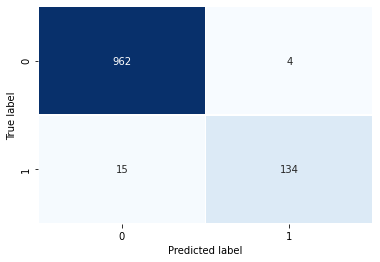

In [ ]:
plot_confusion_matrix(y_test, preds)

In [ ]:
model.save("drive/MyDrive/SpamDetector/spam_model")

INFO:tensorflow:Assets written to: drive/MyDrive/SpamDetector/spam_model/assets


In [ ]:
import pickle

In [ ]:
with open('drive/MyDrive/SpamDetector/spam_model/tokenizer.pkl', 'wb') as output:
   pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)

<h1>Inference</h1>

In [ ]:
s_model = tf.keras.models.load_model("drive/MyDrive/SpamDetector/spam_model")
with open('drive/MyDrive/SpamDetector/spam_model/tokenizer.pkl', 'rb') as input:
    tokenizer = pickle.load(input)

In [ ]:
sms = ["Congratulations! you just won 2 million dollars. Send you account details for processing "]
sms_proc = tokenizer.texts_to_sequences(sms)
sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')
pred = (model.predict(sms_proc) > 0.5).astype("int32").item()
print(pred)

1


https://www.twilio.com/blog/spam-deep-learning-detection-sms-keras-python-twilio

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/#:~:text=Keras%20offers%20an%20Embedding%20layer,API%20also%20provided%20with%20Keras

https://www.google.com/search?q=Deep+Learning+Spam+Detection+System+in+%22django%22&sxsrf=ALeKk008f9XylYqiGooKq0qpIGP8pEfHMw%3A1618066088117&ei=qLpxYOrdBsuYlwTUnIiYDA&oq=Deep+Learning+Spam+Detection+System+in+%22django%22&gs_lcp=Cgdnd3Mtd2l6EAMyBQghEKABMgUIIRCgATIFCCEQoAEyBQghEKABMgUIIRCgAToHCAAQRxCwAzoECCMQJ1D8oQFY1bABYJy5AWgBcAJ4AIABhgOIAe0HkgEFMi0xLjKYAQCgAQGqAQdnd3Mtd2l6yAEIwAEB&sclient=gws-wiz&ved=0ahUKEwjq0Z7z9fPvAhVLzIUKHVQOAsMQ4dUDCA0&uact=5